# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
dynamics = CartpoleDynamics(dt)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = 100 * np.eye(dynamics.state_size)
Q[1, 1] = Q[4, 4] = 10.0

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[1.0]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 194868.65084603959 [0.05659299 0.09608351 0.86735578 0.88489984]
iteration 1 accepted 194402.38304282707 [0.12130671 0.23701194 0.87990196 0.83622739]
iteration 2 accepted 193922.49600984613 [0.01225405 0.05027257 0.61312412 0.2503636 ]
iteration 3 accepted 193631.02339304177 [0.0283176  0.15317507 0.66497453 0.34450068]
iteration 4 accepted 193316.19567223891 [-0.01207582  0.03125614  0.52856389  0.06258283]
iteration 5 accepted 193058.68686271226 [-0.02824415  0.04721869  0.52236215  0.04991296]
iteration 6 accepted 192799.5655767457 [-0.01989203  0.00498881  0.47670455 -0.03521495]
iteration 7 accepted 192560.97042534247 [-0.01949392 -0.00142939  0.4658193  -0.05315357]
iteration 8 accepted 192325.95061924847 [-0.00992762 -0.02175014  0.44390746 -0.08947589]
iteration 9 accepted 192102.9730300183 [-0.00577537 -0.03121226  0.43198864 -0.10801041]
iteration 10 accepted 191885.64224985853 [ 0.0009406  -0.04208109  0.41875684 -0.12728488]
iteration 11 accepted 19167

iteration 93 accepted 169590.81998452317 [0.13215352 0.18257315 0.06861555 0.21672421]
iteration 94 accepted 169588.9003852844 [0.1391105  0.18667529 0.05440651 0.17663522]
iteration 95 failed 169588.90038528433 [0.1391105  0.18667529 0.05440651 0.17663522]
iteration 96 failed 169588.90038528433 [0.1391105  0.18667529 0.05440651 0.17663522]
iteration 97 accepted 169580.78038367094 [0.15014017 0.18893104 0.04908107 0.16132748]
iteration 98 failed 169580.78038367105 [0.15014017 0.18893104 0.04908107 0.16132748]
iteration 99 failed 169580.78038367105 [0.15014017 0.18893104 0.04908107 0.16132748]
iteration 100 failed 169580.78038367105 [0.15014017 0.18893104 0.04908107 0.16132748]
iteration 101 failed 169580.78038367105 [0.15014017 0.18893104 0.04908107 0.16132748]
iteration 102 accepted 169579.72837894224 [0.15319492 0.18737391 0.05174906 0.16962465]
iteration 103 failed 169579.72837894235 [0.15319492 0.18737391 0.05174906 0.16962465]
iteration 104 converged 169579.62421212016 [0.15384094

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

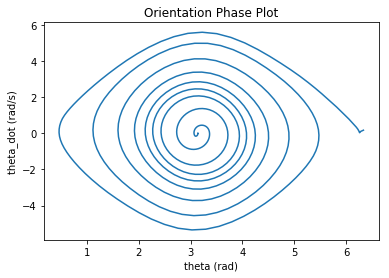

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

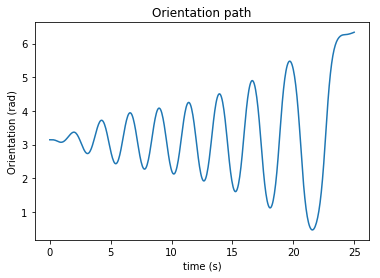

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

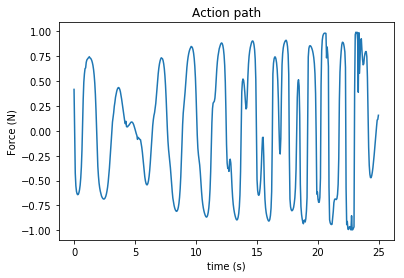

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

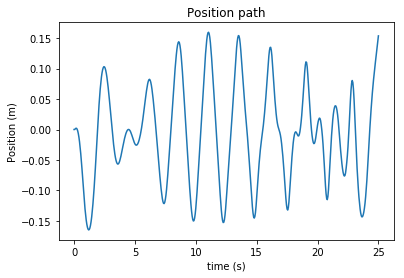

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

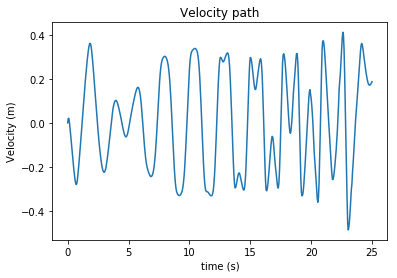

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

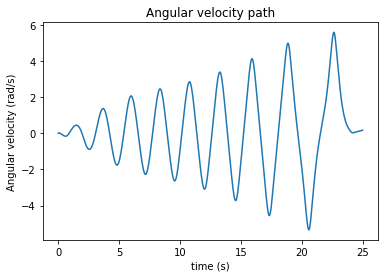

In [17]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

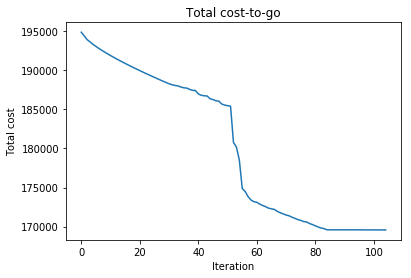

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")